# Аналитика оттока клиентов фитнес-клуба

### План:
1. Загрузим данные и проведём исследовательский анализ данных (EDA).
    - Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения.
    - Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.
    - Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл и тех, кто остался.
    - Построим матрицу корреляций признаков.
    

2. Построим модель прогнозирования оттока пользователей.
    - Разобьём данные на обучающую и валидационную выборку.
    - Обучим модель двумя способами: логистической регрессией и случайным лесом.
    - Оценим метрики для обеих моделей на валидационной выборке. Сравним по ним модели.


3. Сделаем кластеризацию пользователей.
    - Стандартизируем данные.
    - Построим матрицу расстояний на стандартизованной матрице признаков и нарисуем дендрограмму.
    - Обучим модель кластеризации и спрогнозируем кластеры клиентов.
    - Посмотрим на средние значения признаков для кластеров.
    - Построим распределения признаков для кластеров.
    - Для каждого полученного кластера посчитаем долю оттока.


4. Сформулируем выводы и сделаем базовые рекомендации по работе с клиентами.

<a name="researchdata"></a>

## Шаг 1. Откроем файл с данными и изучим общую информацию

Импортируем библиотеки:

In [36]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

import matplotlib.pyplot as plt
import seaborn as sns

# дополнительно зададим фильтр, который будет игнорировать предупреждения, чтобы они не мешали читать код
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Загружаем файл с данными оттока клиентов фитнес-клуба:

In [37]:
gym_data = pd.read_csv('/datasets/gym_churn.csv')

**Посмотрим на общую информацию по датасету**

In [38]:
gym_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Типы данных соответствуют указанным данным, только столбец 'Month_to_end_contract' (количество месяцев) лучше сделать целочисленными:

In [39]:
gym_data['Month_to_end_contract'] = gym_data['Month_to_end_contract'].astype('int')

# проверка
gym_data['Month_to_end_contract'].dtypes

dtype('int64')

**Проверим дубликаты**

In [40]:
gym_data.duplicated().sum()

0

Дубликатов и пропусков нет.

**Посмотрим на сам датасет**

In [41]:
gym_data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1,3,1.113884,1.120078,0


Видим, что часть признаков у нас бинарные (принимают либо значение "0", либо "1"), другие - количественные.

<a name="describe"></a>

**Посмотрим на описательные статистики датасета**

Отдельно рассмотрим статистики для столбцов, которые показывают факт наличия признака (0 или 1), и отдельно показывающих количественные данные:

In [42]:
# бинарные признаки

gym_data[['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits', 'Churn']].describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Group_visits,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,0.412250,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,0.492301,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [43]:
# количественные признаки

display(gym_data[['Age','Lifetime']].describe())

display(gym_data[['Contract_period', 'Month_to_end_contract', 
                  'Avg_class_frequency_total', 'Avg_class_frequency_current_month',
                  'Avg_additional_charges_total']].describe())

,Age,Lifetime
count,4000.000000,4000.000000
mean,29.184250,3.724750
std,3.258367,3.749267
min,18.000000,0.000000
25%,27.000000,1.000000
50%,29.000000,3.000000
75%,31.000000,5.000000
max,41.000000,31.000000


,Contract_period,Month_to_end_contract,Avg_class_frequency_total,Avg_class_frequency_current_month,Avg_additional_charges_total
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,4.681250,4.322750,1.879020,1.767052,146.943728
std,4.549706,4.191297,0.972245,1.052906,96.355602
min,1.000000,1.000000,0.000000,0.000000,0.148205
25%,1.000000,1.000000,1.180875,0.963003,68.868830
50%,1.000000,1.000000,1.832768,1.719574,136.220159
75%,6.000000,6.000000,2.536078,2.510336,210.949625
max,12.000000,12.000000,6.023668,6.146783,552.590740


***Выводы по всем данным***

- Показатель пола распределился практически поровну, мужчинам и женщинам одинаково нравится посещать фитнес-центр.
- Большинство клиентов живут или работают в районе фитнес-центра.
- Почти половина клиентов - сотрудники компаний-партнёров.
- 30% наших клиентов пришли в фитнес по акции "приведи друга".
- Свой телефон предоставили почти все клиенты.
- На групповые занятия ходят примерно 40% клиентов.
- Средний показатель оттока - 26%.


- Средний возраст посетителей - 30 лет.
- Время с момента первого обращения в фитнес-центр в половине случае - 3 месяца, данные свежие.
- При этом не менее чем у половины наших клиентов абонементы оформлены на месяц. Соответственно, и срок окончания у этих абонементов также месяц.
- Средняя частота посещений в неделю за все время с начала действия абонемента и за предыдущий месяц - примерно 2 раза в неделю.
- Также можно увидеть, что средняя выручка от других услуг фитнес-центра составляет 147 y.е.

<a name="describechurn"></a>

**Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался**

Опять же для удобства рассмотрим отдельно показатели для бинарных и количественных признаков.

In [44]:
# сохраним бинарные признаки в отдельный список
features_bin = ['gender', 'Near_Location',
                'Partner', 'Promo_friends', 
                'Phone', 'Group_visits']

# посмотрим средние значения признаков из списка по отдельности
for feature in features_bin:
    print(feature)
    display(gym_data.groupby('Churn')[feature].describe())
    print()

gender


,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,2939.0,0.510037,0.499984,0.0,0.0,1.0,1.0,1.0
1,1061.0,0.510839,0.500118,0.0,0.0,1.0,1.0,1.0



Near_Location


,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,2939.0,0.873086,0.332933,0.0,1.0,1.0,1.0,1.0
1,1061.0,0.768143,0.422217,0.0,1.0,1.0,1.0,1.0



Partner


,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,2939.0,0.534195,0.498914,0.0,0.0,1.0,1.0,1.0
1,1061.0,0.355325,0.478837,0.0,0.0,0.0,1.0,1.0



Promo_friends


,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,2939.0,0.353522,0.478144,0.0,0.0,0.0,1.0,1.0
1,1061.0,0.183789,0.387495,0.0,0.0,0.0,0.0,1.0



Phone


,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,2939.0,0.903709,0.295040,0.0,1.0,1.0,1.0,1.0
1,1061.0,0.902922,0.296204,0.0,1.0,1.0,1.0,1.0



Group_visits


,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,2939.0,0.464103,0.498795,0.0,0.0,0.0,1.0,1.0
1,1061.0,0.268615,0.443448,0.0,0.0,0.0,1.0,1.0


In [45]:
# сохраним количественные признаки в отдельный список
features_col = ['Age','Lifetime',
                'Contract_period', 'Month_to_end_contract', 
                'Avg_class_frequency_total', 'Avg_class_frequency_current_month',
                'Avg_additional_charges_total']

# посмотрим средние значения признаков из списка по отдельности
for feature in features_col:
    print(feature)
    display(gym_data.groupby('Churn')[feature].describe())
    print()

Age


,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,2939.0,29.976523,3.009933,19.0,28.0,30.0,32.0,41.0
1,1061.0,26.989632,2.895163,18.0,25.0,27.0,29.0,38.0



Lifetime


,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,2939.0,4.711807,3.874780,0.0,2.0,4.0,6.0,31.0
1,1061.0,0.990575,1.110799,0.0,0.0,1.0,1.0,9.0



Contract_period


,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,2939.0,5.747193,4.716942,1.0,1.0,6.0,12.0,12.0
1,1061.0,1.728558,2.132371,1.0,1.0,1.0,1.0,12.0



Month_to_end_contract


,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,2939.0,5.283089,4.363522,1.0,1.0,6.0,10.0,12.0
1,1061.0,1.662582,1.964593,1.0,1.0,1.0,1.0,12.0



Avg_class_frequency_total


,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,2939.0,2.024876,1.016006,0.0,1.283137,2.043252,2.732944,6.023668
1,1061.0,1.474995,0.694705,0.0,1.010771,1.491187,1.956438,3.478646



Avg_class_frequency_current_month


,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,2939.0,2.027882,1.018994,0.0,1.297021,2.046697,2.740648,6.146783
1,1061.0,1.044546,0.770237,0.0,0.421337,0.979445,1.588576,3.540271



Avg_additional_charges_total


,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,2939.0,158.445715,99.801599,0.171862,76.920993,149.881171,224.448274,552.59074
1,1061.0,115.082899,77.696419,0.148205,50.629127,103.814686,165.616858,425.53522


***Выводы по данным в разрезе признака оттока***

- Пол по-прежнему распределяется практически поровну среди оставшихся и ушедших. Сразу же можно сказать, что и наличие/отсутствие контактного номера телефона никак не влияет на отток.
- Среди ушедших не менее 75% тех, кто жил или работал рядом с фитнес-центром. Но среди оставшихся средний показатель близости к фитнесу оценивается в 88%. Это говорит о том, что есть небольшое преимущество у тех клиентов, которые живут/работают рядом.
- Интересно, что из оставшихся клиентов не менее половины - это сотрудники компаний-партнёров. Среди ушедших сотрудников партнёров примерно 35%.
- Промо-акция не смогла удержать как минимум 18% пришедших по ней клиентов. Зато среди оставшихся примерно 35% пришли как раз по акции. Профит в 2 раза выше, промо-коды для покупки абонементов - хороший инструмент для увеличения количества лояльных клиентов.
- Групповые занятия гораздо чаще посещают клиенты, которые стабильно ходят заниматься и не думают уходить.


- Средний возраст оставшихся посетителей 30 лет, ушедших в отток - 27 лет.
- Абсолютное большинство (не менее 75% из ушедших в отток) посетителей отваливается в течение первого месяца. Абонементы они также оформляют в среднем на месяц, видимо, пробуют свои силы.
- Клиенты, которые продолжают заниматься, ходят в фитнес чаще, обычно 2 раза в неделю. Клиенты, которые ушли, в среднем ходили в фитнес-клуб 1 раз в неделю. 
- Средняя выручка от других услуг фитнес-центра у ушедших клиентов примерно в 1.4 раза ниже, постоянные клиенты тратят больше.

<a name="distplot"></a>

**Построим гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)**

Изобразим ушедших и тех, кто остался, на одном графике в разрезе признаков: ушедших обозначим красным цветом, оставшихся - зелёным.

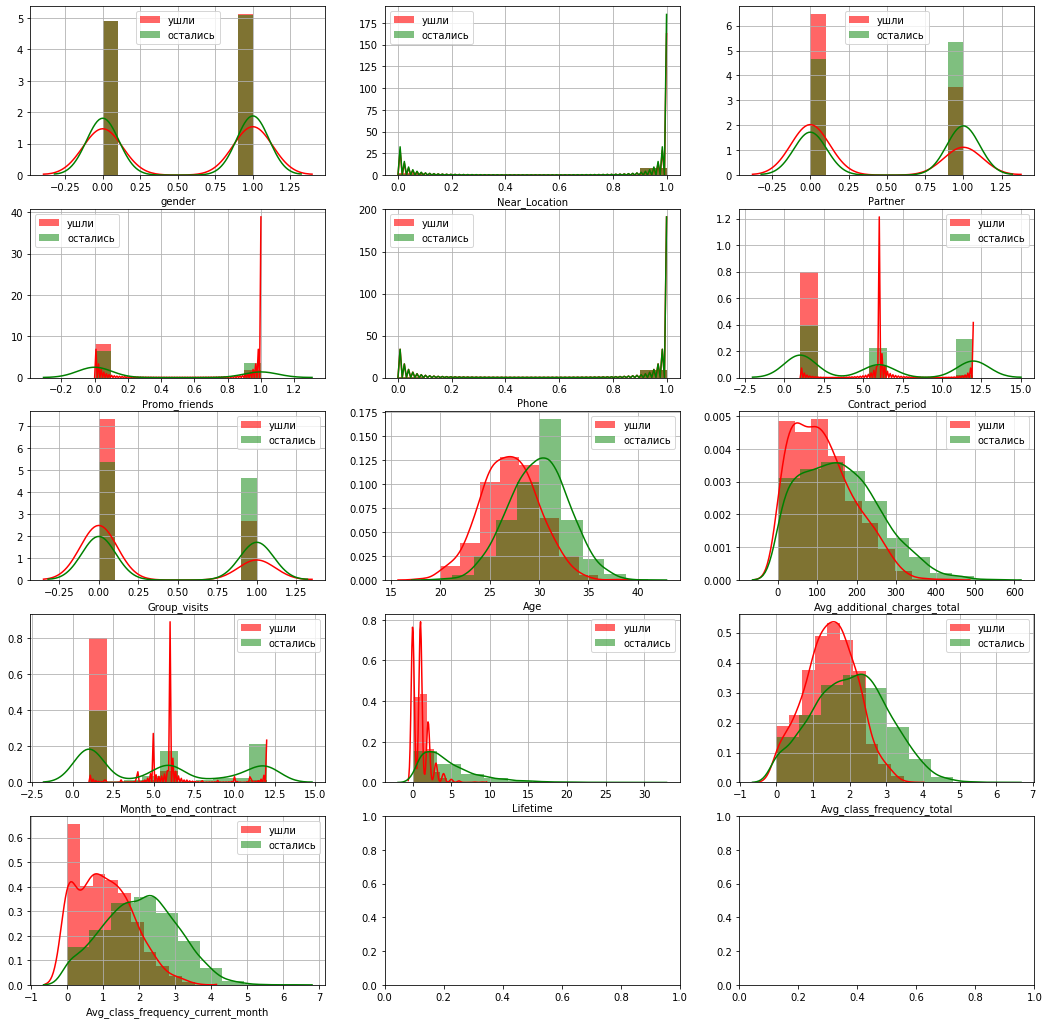

In [46]:
fig, axes = plt.subplots(nrows = 5, ncols = 3, figsize=(18, 18)) 
  
for feature, ax in zip(gym_data.drop('Churn', axis = 1).columns, axes.flat):
    sns.distplot(gym_data.query('Churn == 1')[feature], bins=10, color='r', hist_kws=dict(alpha=0.6), label='ушли', ax = ax)
    sns.distplot(gym_data.query('Churn == 0')[feature], bins=10, color='g', hist_kws=dict(alpha=0.5), label='остались', ax = ax)
    ax.legend()
    ax.grid(True)
    
plt.show() 

***Выводы***

- Пол и расположение фитнес-центра не влияет на отток.
- Чаще уходят те, кто не являются сотрудниками компании-партнёра клуба и не использовали промо-код от знакомых при оплате абонемента.
- Большинство тех, кто перестал ходить в фитнес, брали абонемент на 1-3 месяца. 
- Пользователи, которые ушли, гораздо реже ходили на групповые занятия, чем постоянные клиенты.
- В отток попадают клиенты чуть моложе, но разница не существенна, средний возраст в обеих группах всё равно в районе 30.
- И как мы выяснили раньше, суммарная выручка от ушедших ниже, а посещения в неделю реже, чем у постоянных клиентов. 

<a name="matrixcorr"></a>

**Построим матрицу корреляций**

Вычисляем матрицу корреляций:

In [47]:
cm = gym_data.corr() 

Нарисуем тепловую карту с подписями для матрицы корреляций:

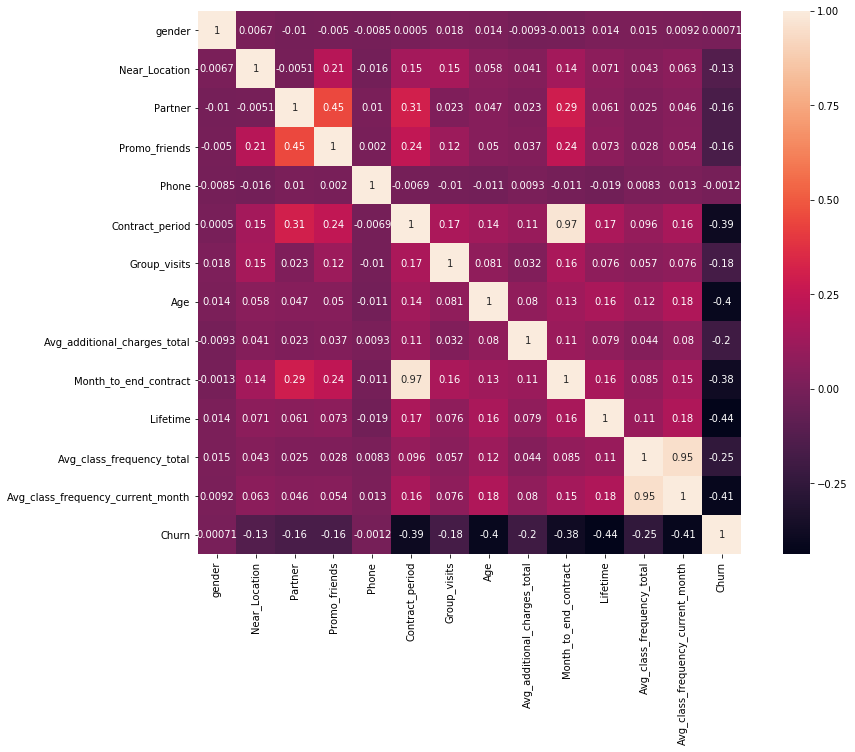

In [48]:
fig, ax = plt.subplots(figsize = (15, 10))

sns.heatmap(cm, annot=True, square = True) 
plt.show()

***Вывод***

Ожидаемо сильно коррелируют между собой:
- "Длительность действующего абонемента" и "Месяцы до окончания абонемента", 
- а также "Средняя частота посещений в неделю за все время" и "Средняя частота посещений в неделю за предыдущий месяц".

Также есть средняя положительная корреляция между признаками "Сотрудник компании-партнёра клуба", "Факт первоначальной записи в рамках акции «приведи друга»" и "Длительность текущего действующего абонемента".

Между остальными признаками зависимости слабые.

<a name="model"></a>

## Шаг 2. Построим модель прогнозирования оттока пользователей

Построим модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце:
1. Разобьём данные на обучающую и валидационную выборку.
2. Обучим модель на train-выборке двумя способами: логистической регрессией и случайным лесом.
3. Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели. 

<a name="traintestsplit"></a>

**Разобьём данные на обучающую и валидационную выборку**

Разделим наши данные на признаки (матрица X) и целевую переменную (y):

In [49]:
X = gym_data.drop('Churn', axis = 1)
y = gym_data['Churn']

Разделяем модель на обучающую и валидационную выборку в процентном соотношении 80 к 20:

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y, shuffle=True)

<a name="fitmodel"></a>

**Обучим модель на train-выборке двумя способами: логистической регрессией и случайным лесом**

Определим функцию, которая будет выводить наши метрики:

In [52]:
def print_all_metrics(y_true, y_pred, title = 'Метрики классификации'):
    """Функция для вывода метрик моделей
    
    Аргументы:
        y_true: результат валидационной выборки
        y_pred: результат прогноза для валидационной выборки
        title: название для набора метрик
    
    Возвращает:
        accuracy_score: доля правильных ответов модели
        precision_score: точность модели (доля правильных ответов только среди целевого класса)
        recall_score: полнота модели (сколько реальных объектов правильного класса мы смогли обнаружить)
        f1_score: сводная метрика, учитывающая баланс между метриками (чем ближе к единице, тем лучше)
        roc_auc_score: метрика вероятности, показывает качество алгоритма (принимает значение от 0 до 1, больше — лучше)
        
    """
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_pred)))

Обучим модель логистической регрессией:

In [53]:
# зададим алгоритм
lr_model = LogisticRegression(random_state=0)

# обучим модель
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Обучим модель случайным лесом:

In [54]:
# зададим алгоритм
# число деревьев, на основании которых будем строить лес (параметр n_estimators), зададим равным 100
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 

# обучим модель случайного леса
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

<a name="metrics"></a>

**Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке и сравним по ним модели**

Воспользуемся моделью, обученной логистической регрессией, чтобы сделать бинарный прогноз и выведем все метрики для полученного прогноза:

In [55]:
# делаем прогноз
lr_predictions = lr_model.predict(X_test)

# выводим метрики для модели логистической регрессии
print_all_metrics(y_test, lr_predictions, title='Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.93
	Precision: 0.89
	Recall: 0.84
	F1: 0.87
	ROC_AUC: 0.90


Воспользуемся моделью, обученной случайным лесом, чтобы сделать прогноз для неё и выведем аналогичные метрики:

In [56]:
# делаем прогноз
rf_predictions = rf_model.predict(X_test) 

# выводим метрики для модели случайного леса
print_all_metrics(y_test, rf_predictions, title = 'Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.88
	Recall: 0.83
	F1: 0.85
	ROC_AUC: 0.89


***Вывод***

По всем показателям: "Доля правильных ответов" (Accuracy), "Точность" (Precision), "Полнота" (Recall), сводная метрика (f1-score) и метрика вероятности (ROC_AUC), модель, обученная алгоритмом логистической регресии, показала результаты лучше, чем модель, обученная алгоритмом случайного леса.

<a name="clusterization"></a>

## Шаг 3. Кластеризация пользователей

Отложим в сторону столбец с оттоком и проведём кластеризацию пользователей:
1. Стандартизируем данные.
2. Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму. 
3. Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. 
4. Посмотрим на средние значения признаков для кластеров. 
5. Построим распределения признаков для кластеров. 
6. Для каждого полученного кластера посчитаем долю оттока.

<a name="scaler"></a>

**Стандартизируем данные**

Создадим объект класса scaler (нормализатор):

In [57]:
scaler = StandardScaler()

Обучаем нормализатор и преобразуем набор данных X (помним, что X = gym_data.drop('Churn', axis = 1), т.е. это наши данные без ключевого параметра оттока):

In [58]:
X_sc = scaler.fit_transform(X)

<a name="linkage"></a>

**Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму**

Передадим получившуюся стандартизированную таблицу X_sc в качестве параметра функции linkage(). Чтобы диаграмма получилась показательной, передадим параметру method значение 'ward':

In [59]:
linked = linkage(X_sc, method = 'ward') 

В переменной linked мы сохранили таблицу связок между объектами. Визуализируем её как дендрограмму:

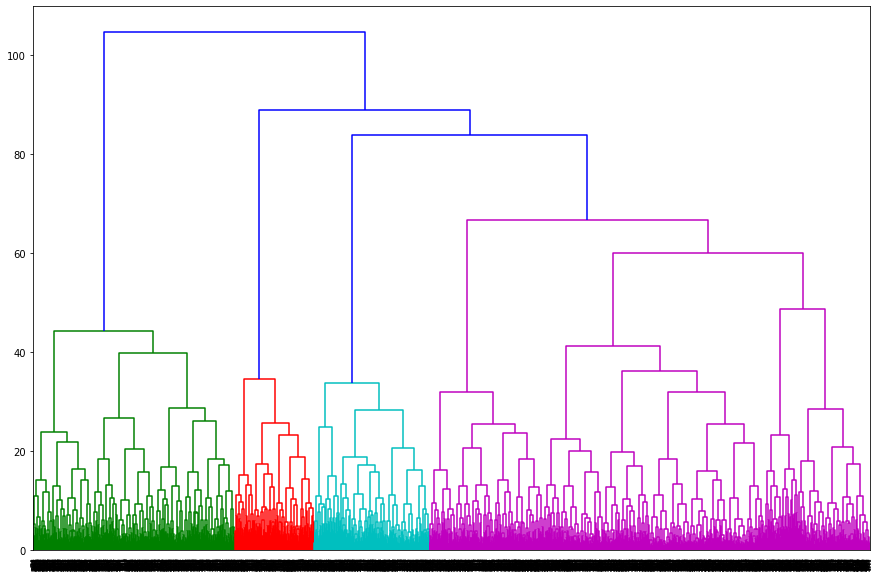

In [27]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

На основании полученного графика можно предложить оптимальное число кластеров 4 — четыре разных цвета на графике. Но по условию задачи далее мы будем считать, что у нас 5 кластеров.

<a name="fitkmeans"></a>

**Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов**

Обучим модель алгоритмом K-Means, зададим число кластеров, равное 5:

In [60]:
km = KMeans(n_clusters = 5, random_state=0)

Применим алгоритм к данным и сформируем вектор кластеров:

In [61]:
labels = km.fit_predict(X_sc)

<a name="clustersmean"></a>

**Посмотрим на средние значения признаков для кластеров**

Сохраним полученные метки кластера в новый столбец нашего датасета:

In [62]:
gym_data['Cluster_client'] = labels

Выведем статистику по средним значениям наших признаков по кластеру:

In [63]:
gym_data.groupby('Cluster_client').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
Cluster_client,,,,,,,,,,,,,,
0,0.502473,0.959446,0.783383,0.574679,1.000000,10.884273,0.543027,29.980218,160.706969,9.950544,4.738872,1.983305,1.976225,0.027695
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.560335,0.976105,0.356033,0.229391,0.998805,2.665472,0.473118,30.127838,161.724258,2.455197,4.896057,2.851531,2.849473,0.068100


***Выводы***

Как мы помним, некоторые признаки у нас бинарные, а некоторые количественные. Посмотрим на средние значения с учётом этой информации:
- По полу клиенты распределились в кластерах примерно равномерно.
- Во всех кластерах, кроме 2, большинство клиентов проживают/работают в районе фитнес-центра.
- В кластере 0 гораздо больше сотрудников компаний-партнёров клуба по сравнению с другими кластерами.
- И ещё кластер 0 отличается тем, что в нём много клиентов, которые пришли по акции "приведи друга".
- Телефоны стабильно оставляют все клиенты, кроме клиентов из кластера 1.
- Судя по средним периодам действующих абонементов, в кластере 0 клиенты в основном с абонементом на год, в 1 - на 3-6 месяцев, во 2, 3 и 4 - на 1-3 месяца.
- По групповым занятиям видим численное преимущество у кластера 0 (видимо, годовой абонемент побуждает чаще пробовать разные групповые программы), меньше всего клиентов, посещающих групповые классы, в кластере 2.
- Средний возраст во всех кластерах примерно одинаковый: 28-30 лет.
- Наибольшую среднюю суммарную выручку от других услуг фитнес-центра показывают кластеры 0 и 4.
- Лайфтайм наших кластеров на момент исследования в среднем от 2 до 5 месяцев. Самый низкий в 3 кластере (2.4 месяца), самый высокий в 4 и 0 (4.9 и 4.7 соответственно).
- Средняя частота посещений в неделю за всё время и за предыдущий месяц сильно выше в 4 кластере (клиенты посещают фитнес 2-3 раза в неделю), стабильно средняя посещаемость 2 раза в неделю в кластерах 0 и 1, во 2 кластере в среднем в фитнес ходят 1-2 раза в неделю и ниже всего посещаемость в 3 кластере (примерно 1 раз в неделю).
- Практически нулевой отток в 0 и 4 кластере. В 1 составляет в среднем 1/4 от всех клиентов. А в кластерах 2 и 3 в отток уходит в среднем половина клиентов.

Учитывая выводы выше, можно сказать, что клиенты из **кластера 0 ведут** себя наиболее лояльно:
- оформляют абонементы на год, 
- часто ходят на групповые занятия, 
- посещают фитнес 2 раза в неделю, 
- приносят дополнительную выручку, пользуясь другими услугами фитнес-центра, 
- при этом больше половины из них пришли по акции "приведи друга", 
- работают/проживают в районе фитнес-клуба, 
- а также показывают самый низкий показатель оттока.

Ещё один интересный кластер для нас с низкой долей оттока - **кластер 4**:
- они ходят в фитнес дольше (их средний лайфтайм на момент исследования 4.9 месяцев) и чаще (в среднем 2-3 раза в неделю) остальных кластеров,
- по средней суммарной выручке за доп. услуги они делят первое место с кластером 0,
- среди них достаточно мало (меньше 1/4) тех, кто пришёл бы в клуб по акции,
- сотрудников компаний-партнёров среди них также немного (примерно 1/3),
- абонементы оформляют в основном на 1-3 месяца (3-месячных больше),
- судя по высокому среднему показателю близости места работы/проживания к фитнес-центру, многие из них выбрали клуб именно из-за территориального расположения.

<a name="clustersdistplot"></a>

**Построим распределения признаков для кластеров**

Построим графики распределения. Для количественных признаков график будет в виде boxplot, а для бинарных признаков - distplot.

Признак gender


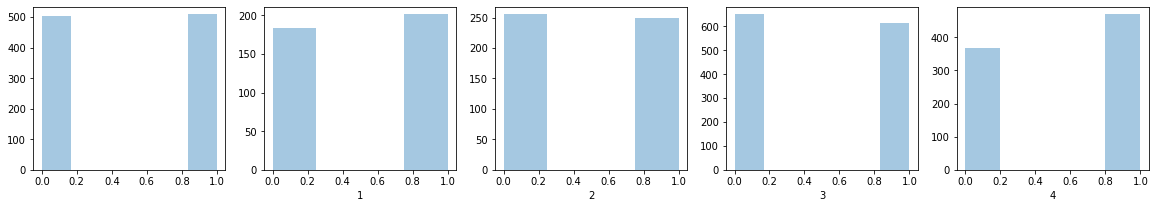

Признак Near_Location


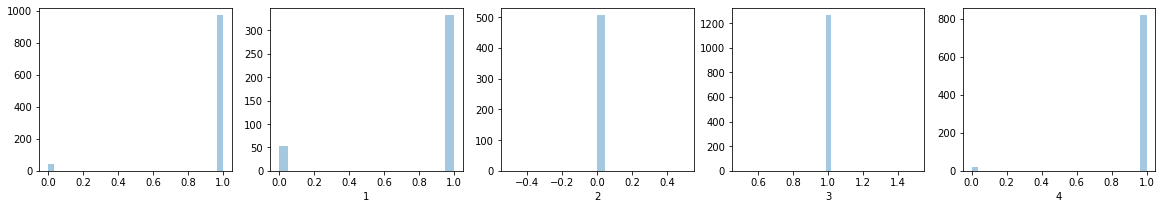

Признак Partner


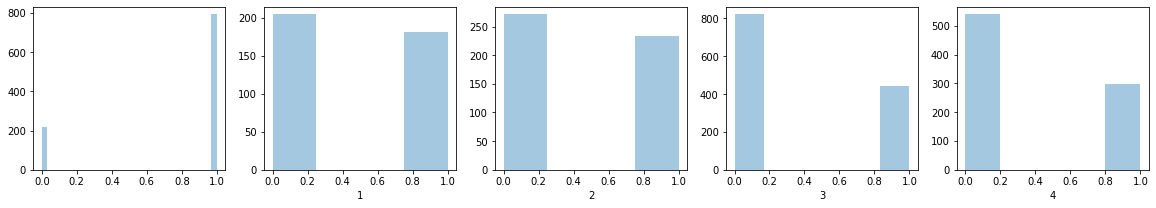

Признак Promo_friends


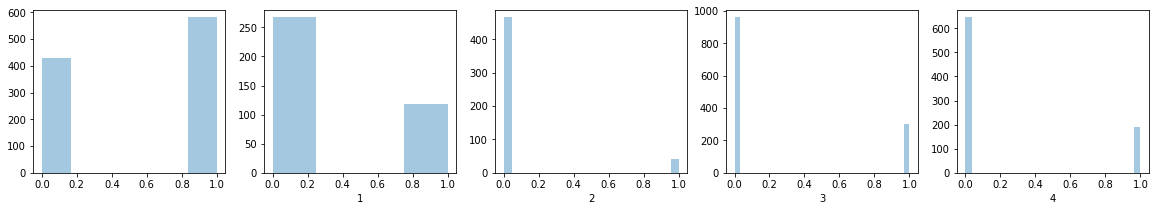

Признак Phone


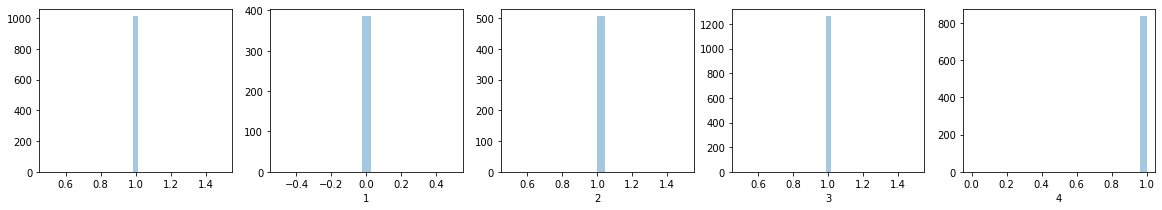

Признак Group_visits


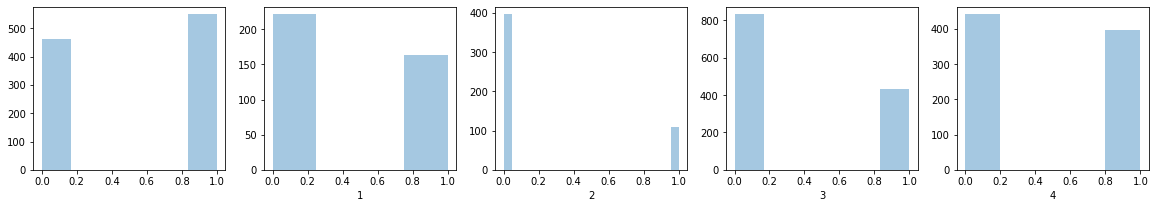

Признак Churn


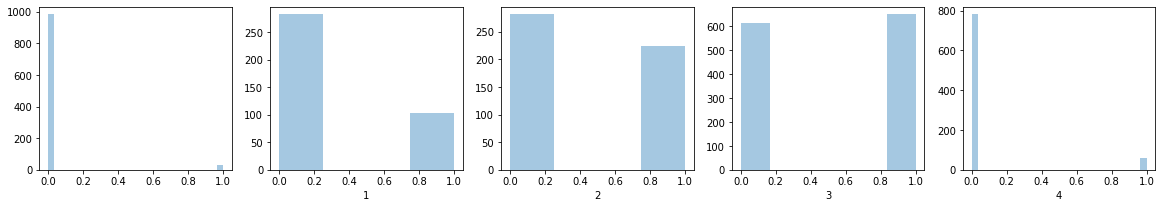

In [64]:
# возьмём созданный ранее список с бинарными признаками
features_bin = ['gender', 'Near_Location',
                'Partner', 'Promo_friends', 
                'Phone', 'Group_visits',
                'Churn']

# посмотрим на распределения значений признаков из списка в виде distplot

for feature in features_bin:
    # создали список с номерами 5 кластеров по возрастанию
    gym_cls = gym_data['Cluster_client'].sort_values().unique() 
    
    # создали для каждого признака свою строку с 5-ю колонками
    fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize=(20, 3)) 
    
    # выводим название признака
    print('Признак ' + feature)
    
    # перебираем в цикле все признаки, при этом для каждого кластера строим отдельный график
    for gym_cl, ax in zip(gym_cls, axes.flat):
        sns.distplot(gym_data[gym_data['Cluster_client'] == gym_cl][feature], axlabel=gym_cl, ax = ax, kde=False);

    plt.show();

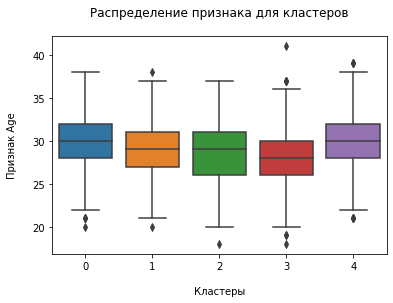

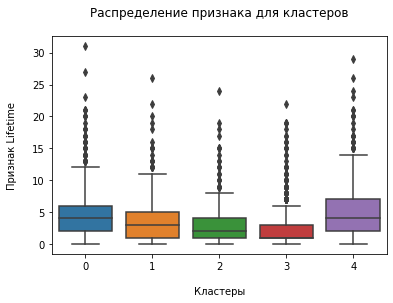

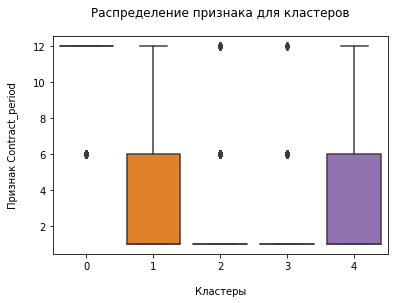

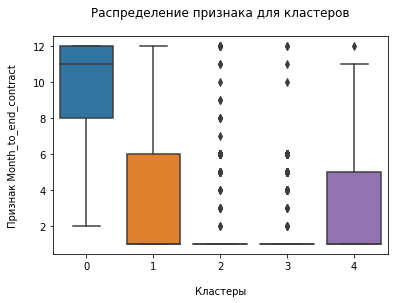

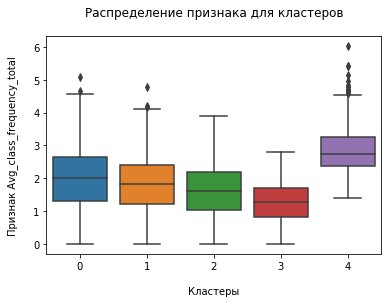

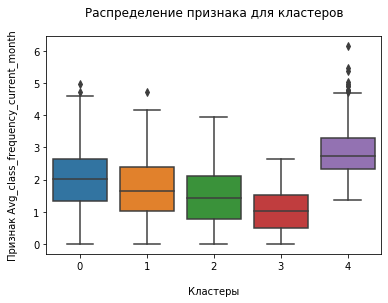

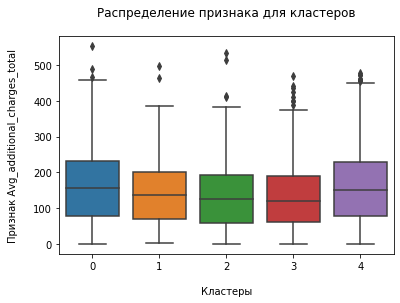

In [65]:
# возьмём созданный ранее список с количественными признаками
features_col = ['Age', 'Lifetime',
            'Contract_period', 'Month_to_end_contract', 
            'Avg_class_frequency_total', 'Avg_class_frequency_current_month',
            'Avg_additional_charges_total']

# посмотрим на распределения значений признаков из списка в виде boxplot
for feature in features_col:
    sns.boxplot(x='Cluster_client', y=feature, data=gym_data)
    plt.title('Распределение признака для кластеров', pad=20)
    plt.xlabel('Кластеры', labelpad = 15)
    plt.ylabel('Признак ' + feature, labelpad = 15)
    plt.show() 

***Выводы***

Выводы из графиков подтверждают выводы, сделанные на предыдущем шаге: 
- пол, возраст и лайфтайм клиента влияния не имеют, распределение по кластерам примерно равномерное,
- во всех кластерах, кроме 2, большинство клиентов живут/работают в районе фитнес-центра,
- по двум признакам: сотрудник компании-партнёра и покупка абонемента по акции, больше всего клиентов входят в кластер 0,
- групповые занятия чаще посещают клиенты из кластеров 0 и 4,
- самый большой отток в кластере 3, самый низкий в кластерах 0 и 4,
- периоды оформленных абонементов примерно одинаково распределились в кластерах 1 и 4 (от 1 до 6 месяцев), в кластерах 2 и 3 клиенты обычно берут абонемент на 1 месяц, а в кластере 0 - на год,
- чаще ходят заниматься спортом клиенты из кластеров 4 и 0, реже всех - из кластера 3,
- суммарная выручка чуть выше остальных групп в кластерах 0 и 4.

По-прежнему, **кластеры 0 и 4** для нас наиболее интересны.

<a name="clusterschurn"></a>

**Посчитаем долю оттока для полученных кластеров**

Поделим количество ушедших клиентов (т.к. Churn бинарный признак, для этого нужно посчитать сумму всех строк со значением "1") на общее количество клиентов в каждом кластере (количество строк):

In [66]:
gym_data.groupby('Cluster_client')['Churn'].sum() / gym_data.groupby('Cluster_client')['Churn'].count()

Cluster_client
0    0.027695
1    0.267532
2    0.443564
3    0.514263
4    0.068100
Name: Churn, dtype: float64

***Выводы***

Кластеры 0 и 4 наиболее надёжны, отток клиентов в них практически нулевой.

Кластер 1 теряет примерно 1/4 клиентов, кластеры 2 и 3 в среднем теряют почти половину клиентов.

<a name="conclusion"></a>

## Шаг 4. Выводы и базовые рекомендации по работе с клиентами

В этом блоке **выводы и рекомендации для маркетологов**. В блоке ниже общие выводы по всем рассмотренным параметрам.


Наши ***целевые группы***: сотрудники компаний-партнёров и те, кто живёт рядом с фитнес-центром.

Можно предложить следующие ***меры по снижению оттока***:
1. Продолжать развивать партнёрство в совокупности с акцией с компаниями, офисы которых находятся в районе фитнес-центра. 

Так мы получаем весомую долю лояльных клиентов, которые оформляют абонементы на длительный период, стабильно ходят заниматься в клуб и пользуются доп.услугами, принося дополнительную выручку.

2. Расширять или, как минимум, не снижать ассортимент групповых программ и доп.услуг - лояльные клиенты их любят. 

Возможно, за счёт этого они и ходят в фитнес-центр 2-3 раза в неделю вместо 1-го (большинство клиентов в оттоке ходили в клуб не чаще 1 раза в неделю).

3. Попробовать предлагать оформить абонементы на 6-12 месяцев со скидкой/

Т.к. сейчас большинство тех, кто ушёл, покупали абонемент на месяц, предлагая абонементы со скидкой на 6-12 месяцев, можно стимулировать посетителей заключать долгосрочные контракты с фитнес-центром. Так у посетителей будет меньше соблазна бросить заниматься спортом в первый же месяц.

4. Промо-коды "приведи друга" также положительно влияют на динамику прихода новых клиентов. 

Сейчас ими пользуются в основном сотрудники компаний-партнёров. Можно попробовать расширить зону охвата промо-кодами и предлагать их текущим лояльным клиентам (например, которые посещают клуб стабильно последние 3 месяца), чтобы они приводили своих друзей и знакомых.

**Более подробные выводы**

***1. Влияние признаков:***

- Пол, возраст, наличие контактного телефона не влияют на отток.
- Большинство клиентов живут или работают в районе фитнес-центра, но по сравнению с оставшимися клиентами в оттоке количество людей, живующих/работающих рядом, ниже. Т.е. локация играет некоторую роль.
- Почти половина клиентов - сотрудники компаний-партнёров. Чаще уходят те, кто не являются сотрудниками компании-партнёра клуба и не использовали промо-код от знакомых при оплате абонемента.
- 30% наших клиентов пришли в фитнес по акции "приведи друга". Если смотреть в разрезе показателя оттока, то промо-акция не смогла удержать как минимум 18 % пришедших по ней клиентов. Зато среди оставшихся примерно 35% пришли как раз по акции. Профит в 2 раза выше, промо-коды для покупки абонементов - хороший инструмент для увеличения количества лояльных клиентов.
- На групповые занятия ходят примерно 40% клиентов. При этом их гораздо чаще посещают клиенты, которые стабильно ходят заниматься и не думают уходить.
- Клиенты, которые продолжают заниматься, ходят в фитнес чаще, обычно 2 раза в неделю. Клиенты, которые ушли, в среднем ходили в фитнес-клуб 1 раз в неделю. 
- Средняя выручка от других услуг фитнес-центра у ушедших клиентов примерно в 1.4 раза ниже, постоянные клиенты тратят больше.
- Абсолютное большинство (не менее 75% из ушедших в отток) посетителей отваливается в течение первого месяца. Абонементы они также оформляют в среднем на месяц, видимо, пробуют свои силы.

***2. Корреляции признаков между собой:***

Ожидаемо сильно коррелируют между собой признаки:
- "Длительность действующего абонемента" и "Месяцы до окончания абонемента", 
- а также "Средняя частота посещений в неделю за все время" и "Средняя частота посещений в неделю за предыдущий месяц".

Также есть средняя положительная корреляция между признаками "Сотрудник компании-партнёра клуба", "Факт первоначальной записи в рамках акции «приведи друга»" и "Длительность текущего действующего абонемента".

Между остальными признаками зависимости слабые.